Future needs for project:
- Input try/exception into the API call to account for errors (limit exceeded, etc.)
- random date generator to get weather data for dates that weren't associated with fires
- rolling totals/avg as predictors for the following - precipitation sum (maybe 30 day rolling, percentage of days it rained multiplied by total amount), average relative humidity (weekly lag?), and adding in evapotranspiration. 

In [1]:
# imports and installs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import requests
from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Functions

In [2]:
# Function for generating random dates not present in original fire dataset.
# To be used for weather data not associated with fires.

def rand_date(input_df, record_length = 1000):
    minimum_date = input_df["date"].min() # Initializing range of dates associated with df
    maximum_date = input_df["date"].max()

    listed_date = [minimum_date] # Initializing list of dates with minimum
    new_dates = []

    while minimum_date != maximum_date: # All dates not associated with fires 
        minimum_date += timedelta(days=1)
        if minimum_date in input_df["date"]:
            pass
        else:
            listed_date.append(minimum_date)

    for i in range(record_length): # Random generation of dates not associated with fire
        rand_num = np.random.randint(0, len(listed_date))
        curr_date = listed_date[rand_num]
        new_dates.append(curr_date)

    return pd.Series(new_dates)

## Gathering Data - Historical and API

In [3]:
# Reading in random samples from historical data of a given length.
record_length = 2000
directory = "/Users/coleparker/Documents/Udemy/Personal Challenges/Fire_Prediction/"
file_name = "Fire_Occurrence_Data_2000_2022.csv"

# Reading in fire data and dropping unnecessary columns for analysis
df_fire_full = pd.read_csv(directory + file_name)
df_fire_cleaned = df_fire_full.drop(     
    [
        "Serial",
        "FireCategory",
        "Area",
        "DistrictName",
        "UnitName",
        "FullFireNumber",
        "Cause_Comments",
        "LatLongDD",
        "FO_LandOwnType",
        "Twn",
        "Rng",
        "Sec",
        "Subdiv",
        "LandmarkLocation",
        "County",
        "RegUseZone",
        "RegUseRestriction",
        "Industrial_Restriction",
        "DistrictCode",
        "UnitCode",
        "DistFireNumber",
    ],
    axis=1,
)

# Pulling in most recent 700 observations 
df_fire_cleaned.sort_values(["ReportDateTime"], inplace=True, ascending=False)
df_fire_cleaned = df_fire_cleaned.sample(n=record_length)

# Dropping any null rows
df_fire_cleaned = df_fire_cleaned.dropna()

# Converting datetime columns to appropriate datatype
df_fire_cleaned["Ign_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Ign_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)
df_fire_cleaned["Control_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Control_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)

# Invalid data where the controlled datetime occured before the ignite datetime. 
df_fire_cleaned = df_fire_cleaned.drop(
    df_fire_cleaned.index[
        df_fire_cleaned["Control_DateTime"] < df_fire_cleaned["Ign_DateTime"]
    ].tolist()
)

### API Call

The below cell is retrieving weather data associated with the historical fire data and also pulling weather data for dates which are NOT present in the historical fire data. 

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=5)
openmeteo = openmeteo_requests.Client(session=retry_session)

hourly_dataframe_agg = pd.DataFrame()
daily_dataframe_agg = pd.DataFrame()

for point in tqdm(range(len(df_fire_cleaned))):
    lat_current = df_fire_cleaned["Lat_DD"].iloc[point]
    long_current = df_fire_cleaned["Long_DD"].iloc[point]

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"

    # Model is built to determine fire ignition probability - using Ign_DateTime as date param
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "end_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "hourly": ["soil_moisture_0_to_7cm", "surface_pressure", "dew_point_2m",
                   "apparent_temperature", "precipitation"],
        "daily": ["wind_speed_10m_max", "et0_fao_evapotranspiration", "temperature_2m_max", "temperature_2m_min"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    # Retrieve hourly data from API. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    # Initializing dictionary with appropriate dates for hourly interval data
    # Hourly variables cut off at the end of the day of ignition
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.Time(), unit="s", utc=True).replace(hour=23, minute=59, second=59),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm[:len(hourly_data['date'])]
    hourly_data["surface_pressure"] = hourly_surface_pressure[:len(hourly_data['date'])]
    hourly_data["dew_point_2m"] = hourly_dew_point_2m[:len(hourly_data['date'])]
    hourly_data["apparent_temperature"] = hourly_apparent_temperature[:len(hourly_data['date'])]
    hourly_data["precipitation"] = hourly_precipitation[:len(hourly_data['date'])]

    # Resizing the daily fire data by duplicating entries based on number of hourly observations
    hourly_dataframe = pd.DataFrame(data=hourly_data)
    df_fire_cleaned_repeat_hour = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(hourly_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )

    # Combining the hourly weather data with the duplicated fire entries
    hourly_dataframe = pd.concat([hourly_dataframe, df_fire_cleaned_repeat_hour], axis=1)
    hourly_dataframe_agg = pd.concat(
        [hourly_dataframe_agg, hourly_dataframe], ignore_index=True, axis=0
    )

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

    # Initializing dictionary with appropriate dates for daily interval data
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit = "s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min

    # Ensuring weather API df and associated fire df are rightsized then combining
    daily_dataframe = pd.DataFrame(data=daily_data)
    df_fire_cleaned_repeat_day = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(daily_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )
    daily_dataframe = pd.concat([daily_dataframe, df_fire_cleaned_repeat_day], axis=1)
    daily_dataframe_agg = pd.concat(
        [daily_dataframe_agg, daily_dataframe], ignore_index=True, axis=0
    )

# Getting random dates not associated with fires. Weather details will be 
# used for class 0 entries in the df - no fire ignited.
generated_dates = rand_date(daily_dataframe_agg, 2000)
extra_hourly_dataframe_agg = pd.DataFrame()
extra_daily_dataframe_agg = pd.DataFrame()

for point in tqdm(range(len(generated_dates))):
    lat_long_modulo = point % len(df_fire_cleaned)
    lat_current = df_fire_cleaned["Lat_DD"].iloc[lat_long_modulo]
    long_current = df_fire_cleaned["Long_DD"].iloc[lat_long_modulo]

    # In this call, pass the randomly generated date to the start and end param
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "end_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "hourly": ["soil_moisture_0_to_7cm", "surface_pressure", "dew_point_2m",
                   "apparent_temperature", "precipitation"],
        "daily": ["wind_speed_10m_max", "et0_fao_evapotranspiration", "temperature_2m_max", "temperature_2m_min"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.Time(), unit="s", utc=True).replace(hour=23, minute=59, second=59),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm[:len(hourly_data['date'])]
    hourly_data["surface_pressure"] = hourly_surface_pressure[:len(hourly_data['date'])]
    hourly_data["dew_point_2m"] = hourly_dew_point_2m[:len(hourly_data['date'])]
    hourly_data["apparent_temperature"] = hourly_apparent_temperature[:len(hourly_data['date'])]
    hourly_data["precipitation"] = hourly_precipitation[:len(hourly_data['date'])]

    # No need to resize the weather API df since we are not combining with the fire data
    extra_hourly_dataframe = pd.DataFrame(data=hourly_data)
    extra_hourly_dataframe_agg = pd.concat(
        [extra_hourly_dataframe_agg, extra_hourly_dataframe], ignore_index=True, axis=0
    )

    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min

    # No need to resize the weather API df since we are not combining with the fire data
    extra_daily_dataframe = pd.DataFrame(data=daily_data)
    extra_daily_dataframe_agg = pd.concat(
        [extra_daily_dataframe_agg, extra_daily_dataframe], ignore_index=True, axis=0
    )

# Combining the fire-related df's and the non-fire-related df's
hourly_dataframe_agg = pd.concat(
    [hourly_dataframe_agg, extra_hourly_dataframe_agg], ignore_index=True, axis=0
)
daily_dataframe_agg = pd.concat(
    [daily_dataframe_agg, extra_daily_dataframe_agg], ignore_index=True, axis=0
)

  0%|          | 0/1977 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


## Conversions and Cleanup

In [5]:
# Replacing size class with numeric values - we consider all levels of 
# fire the same since this model is aimed at measuring ignition, not severity
size_class_dict = {"A": 1, "B": 1, "C": 1, "D": 1, "E": 1, "F": 1}
daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].map(
    size_class_dict
)
hourly_dataframe_agg["Size_class"] = hourly_dataframe_agg["Size_class"].map(
    size_class_dict
)

# Converting to UTC datetime
daily_dataframe_agg["date"] = daily_dataframe_agg["date"].dt.tz_convert("UTC")
hourly_dataframe_agg["date"] = hourly_dataframe_agg["date"].dt.tz_convert("UTC")

In [8]:
# Adding a column at the date level
hourly_dataframe_agg['day'] = hourly_dataframe_agg['date'].dt.date

# Dropping columns not used in the model for analysis
hourly_dataframe_agg.drop(
    [
        "FireYear"
        , "FireName"
        , "EstTotalAcres"
        , 'Protected_Acres'
        , 'HumanOrLightning'
        ,'CauseBy'
        , 'GeneralCause'
        , 'SpecificCause'
        , 'Lat_DD'
        , 'Long_DD'
        , 'Ign_DateTime'
        , 'ReportDateTime'
        , 'Discover_DateTime'
        , 'Control_DateTime'
        , 'CreationDate'
        , 'ModifiedDate'
        , 'date'
    ],
    axis=1,
    inplace=True,
)

# Records with no fire assocation have a null Size_class from previous dictionary mapping.
# Converting to 0 to indicate no fire.
hourly_dataframe_agg["Size_class"] = hourly_dataframe_agg["Size_class"].fillna(value=0.0)

# Aggregating the hourly data - all are averages except for precipitation, a sum.
daily_addhourly_dataframe_agg = hourly_dataframe_agg.groupby(
    [
        "day"
        , "Size_class"
    ],
    as_index=False,
).agg({'soil_moisture_0_to_7cm': 'mean', 'surface_pressure': 'mean'
       , 'dew_point_2m': 'mean', 'apparent_temperature': 'mean'
       , 'precipitation': 'sum'})

# Adding a column at the date level
# and dropping columns not used in the model for analysis
daily_dataframe_agg['day'] = daily_dataframe_agg['date'].dt.date
daily_dataframe_agg.drop(
    [
        "FireYear"
        , "FireName"
        , "EstTotalAcres"
        , 'Protected_Acres'
        , 'HumanOrLightning'
        ,'CauseBy'
        , 'GeneralCause'
        , 'SpecificCause'
        , 'Lat_DD'
        , 'Long_DD'
        , 'Ign_DateTime'
        , 'ReportDateTime'
        , 'Discover_DateTime'
        , 'Control_DateTime'
        , 'CreationDate'
        , 'ModifiedDate'
        , 'date'
    ],
    axis=1,
    inplace=True,
)

daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].fillna(value=0.0)

# Merging the aggregated hourly and the daily df's
daily_dataframe_merged = daily_dataframe_agg.merge(
    daily_addhourly_dataframe_agg, on=["day", "Size_class"], how="left"
)

## Visualizing Features

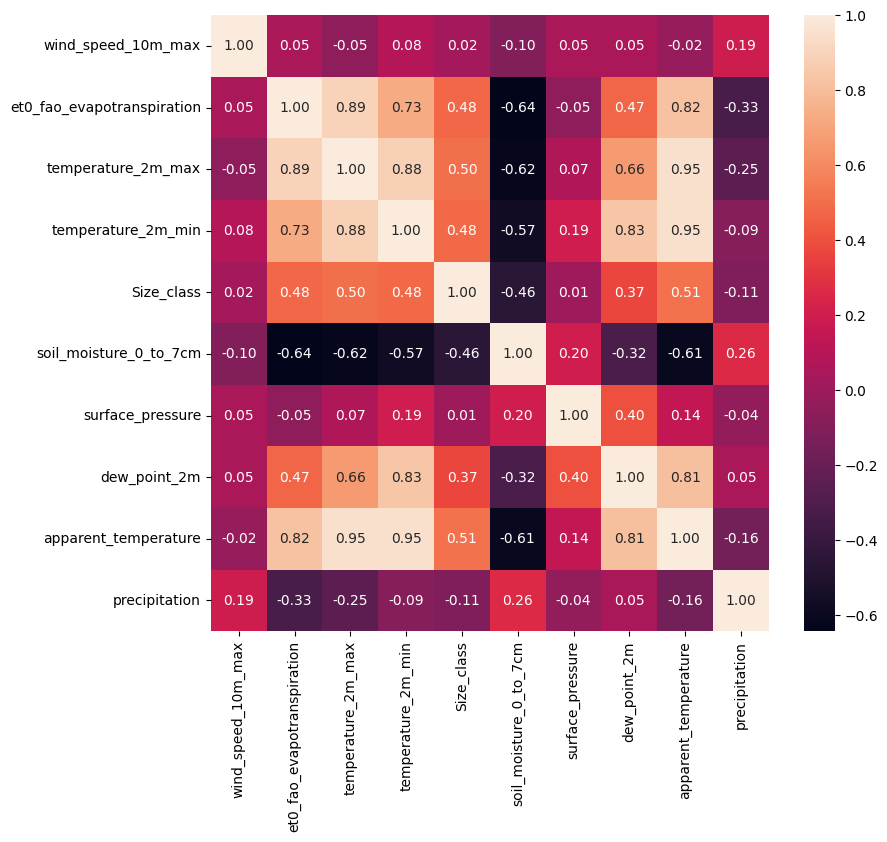

In [9]:
# Visualization to compare size class correlations with numeric variables
plt.figure(figsize=(9, 8))
sns.heatmap(daily_dataframe_merged.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

## Training & Model Evaluation

Based on the below GridSearch, the best parameters were as follows: {'C': 1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}

{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}

In [10]:
# Initializing and training an ensemble model for classification. Precision & 
# Recall used to identify performance instead of pure accuracy. 

pd_X = daily_dataframe_merged.drop(["Size_class", "day"], axis=1)
pd_y = daily_dataframe_merged["Size_class"]
X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.2)

# GridSearch to optimize hyperparameters based on the f1 score
param_grid_RFC = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, None],
    'max_features': [1, 3, 5, 7],
    'min_samples_leaf':[1, 2, 3],
    'min_samples_split':[2, 3]
}

# Instantiating model
RFC = RandomForestClassifier()

# GridSearch over parameters - n_jobs = -1 to improve speed, and optimizing f1 score 
# instead of accuracy.
grid_RFC = GridSearchCV(estimator = RFC, param_grid=param_grid_RFC, verbose = 0, cv = 3, n_jobs=-1, scoring='f1_micro')
grid_RFC.fit(X_train, y_train)
grid_pred = grid_RFC.predict(X_test)

print('The classification report below:')
print(classification_report(y_test, grid_pred), flush = True)
print('\n')
print('The best parameters for the GridSearch:')
print(grid_RFC.best_params_, flush = True)

The classification report below:
              precision    recall  f1-score   support

         0.0       0.79      0.70      0.74       394
         1.0       0.73      0.82      0.78       402

    accuracy                           0.76       796
   macro avg       0.76      0.76      0.76       796
weighted avg       0.76      0.76      0.76       796



The best parameters for the GridSearch:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}


## New Data Prediction

For context to choose test variables for prediction probabilities, reference the below distribution of features

In [11]:
daily_dataframe_merged.describe().drop(['Size_class'], axis = 1)

,wind_speed_10m_max,et0_fao_evapotranspiration,temperature_2m_max,temperature_2m_min,soil_moisture_0_to_7cm,surface_pressure,dew_point_2m,apparent_temperature,precipitation
count,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000
mean,8.421334,0.141472,68.216537,46.449547,0.269830,941.659790,41.812965,52.784058,0.074116
std,3.268403,0.079726,17.167141,11.927896,0.113666,50.252338,10.087990,15.839882,0.199732
min,1.803527,0.005268,13.435701,-7.476700,0.025647,796.177063,-9.966947,-6.105032,0.000000
25%,6.267593,0.067087,54.709702,38.255901,0.170471,902.357788,36.301258,40.614986,0.000000
50%,7.908989,0.149076,69.871994,48.635597,0.256098,951.912903,43.709663,55.755890,0.000000
75%,9.875792,0.209720,82.226303,55.567398,0.366000,983.691528,49.247864,65.537361,0.039370
max,35.178558,0.395277,114.089005,76.235001,0.513588,1031.407837,62.730713,95.243599,2.338583


In [12]:
# Make feature declarations to test model prediction probabilities - the below
# selections are based on a 'best case' scenario, where weather conditions are
# not favorable to a fire

var_wind_speed = 5
var_evapotranspiration = 0.04
var_temperature_max = 50
var_temperature_min = 20
var_soil_moisture = 0.4
var_surface_pressure = 800
var_dew_point = 30
var_apparent_temperature = 30
var_precipitation = 0.01

# Creating a dataframe to pass to the model
new_weather_data = pd.DataFrame(data = [[var_evapotranspiration
                                         , var_evapotranspiration
                                         , var_temperature_max
                                         , var_temperature_min
                                         , var_soil_moisture
                                         , var_surface_pressure
                                         , var_dew_point
                                         , var_apparent_temperature
                                         , var_precipitation]]
                                , columns = X_test.columns)

print(f"The models predicted probability of a fire starting (class {int(grid_RFC.classes_[1])}) with the given values: "
      , round(grid_RFC.predict_proba(new_weather_data)[0][1] * 100, 2)
      , '%')

The models predicted probability of a fire starting (class 1) with the given values:  1.52 %
